*Author: Christian Camilo Urcuqui López*

GitHub: https://github.com/urcuqui/


        |   | /  |   |  |  |  |  |  |  /  |   |  |  |  |      [0][1][0]   
        |       /    |  |  |  |  |       /    \   \_/  /      [1][1][1]   
        |      /     |  |  |  |  |      /      \  \_/ /       [1][1][1]   
        |  |\  \     |  '--'  |  |  |\  \       \    /        Data science    
        | _| `.__\   |________|  | _| `.__\      |___|
        
        
This notebook includes my notes extracted from the references in order to understand how Generative Adversarial Networks work, a lot of this production is not mine and I would like reference the credit for the authors. 

# Generative Adversarial Network


This is a kind of reinforcement learning and unsupervised learning where two models play together. We will have a real dataset R, a model __G__ knows as *generator* which is going to create fake data that looks just like the genuine data, while **D** is the *discriminator* who is going to evaluate and calculate the differente between the real set and the set that was modified, finally, we are going to have the *I* random noise that goes into the generator as source of entropy.


<img src="https://miro.medium.com/max/1198/1*-gFsbymY9oJUQJ-A3GTfeg.png" >


R, we are going to start with the simplest possible **R**. This function takes a mean and a standard deviation and returns which provides the right shape of a sample data from a Gaussian with those parameters. 

So, given a set of data instances X and a set of labels Y, we are going to have }
+ _Generative_ models capture the joind probability P(X, Y), or just P(X) if there are no labels
+ _Discriminative_ models capture the conditional probability P(Y|X)

<img src="https://developers.google.com/machine-learning/gan/images/generative_v_discriminative.png" >

This is the general architecture of the system

<img src="https://developers.google.com/machine-learning/gan/images/gan_diagram.svg" >

Both the generator and the discrimator are neuronal networks, where the discriminator is a classifier which knows the distribution of the data and how to segment it, in the same way, it has a backpropation which uses the loss from the interactions. 

<img src="https://developers.google.com/machine-learning/gan/images/gan_diagram_discriminator.svg">

During the discriminator's training, the discriminator ignores the generator's loss and uses the discriminator's loss, in the same way, during the generator's training the generator uses its loss.

The discriminator is going to focus to classify both real data and fake from the generator, moreover, the discriminator's loss is going to penalize the discriminator for misclassifiying a real instance as fake or a fake instance as real, finally, the discriminator updates its weights using backpropagation from the discrimator's loss. 

The generator is focuses to make fake data using the feedback from the discriminator, in other words, it learns from it in order to improve its output to be the more real. 

G is integrated by the random input _I_, a neural network, the discriminator's output, generator's loss which penalizes the generator for failing to fool the discriminator.

The *loss functions* use in a GAN are:
+ __minmax loss__
+ __Wasserstein loss__

Due to we have two neural nets we can have two loss functions. 


## GAN Variations




+ *Progressive GANs*, it's generator's first layers produce very low resolution images, and subsequent layers and details. This a kind of technique faster than the others. 

+ *Conditional GANs*, in this technique we can specify the label for each generated instance, completely different from *unconditional GANs* where it produces random outputs. 

+ *Image-to-Image translation* it takes an image as input and map it to a generated output image with different properties. 

+ *CycleGAN* it lerans to transform images from one set into images that could belong to another set. 

+ *Text-to-Image Synthesis* takes text as input and produce images that plausible and described by the text. 

+ *Super-resolution* increases the resolution of images, adding detail where necessary to fill in blurry areas. 

+ *Face inpainting* the idea of this approach is to fill chunks of an image that are blacked out.

+ *Text-to-Speech* some researches explored the application of GANs to produce synthetized speech from text input. 

+ *Deep Convolutional Generative Adversarial Network (DCGAN)* is a direct extension of the GAN, except that it uses convolutional and convolutional-transpose layers in the discriminator and generator models, firt described by [8].

## Examples

### DCGAN




The next example is published in [8], where the idea is to use GAN in a set of celebrities photos. The dataset can be downladed from this URL http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html, which has 202,599 face images.

*Libraries*

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
dataroot = "../../../Datasets/celeba"
workers = 2
batch_size = 128
# Spatial size of training images. All images will be resized to this size using a transformer
image_size = 64
# number of channels in the training images. For color images this is 3
nc = 3
# size of z latent vector (i.e size of generator input)
ngpu = 1

*Loading the data*

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# dataloader 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

*Let's print a set of images*

In [ ]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

The autors [8] mentions that all model weights shall be randomly initialized from a normal distribution with mean=0, stdev=0.02. The next function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. 

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

*DCGAN* image processing
<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" >

*Defining the models*

In [6]:
class Generator(nn.Module):
    
    def __init__(self, nz, ngf, nc, ngpu):
        super(Generator, self).__init__()
        
        # gpus
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
        # Input is Z, going into a convolution
            #torch.nn.ConvTranspose2d(in_channels, out_channels, 
            # kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, 
            # dilation=1, padding_mode='zeros'
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf x 8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
             # state size. (ngf x 4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf x 2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (number_channels - nc) x 64 x 64
        )
    
    def forward(self, input):       
        return self.main(input) 

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self, nc, ndf, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (number of channels - nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (hidden_dim*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, input):       
        return self.main(input)

*Let's build the complete network*

In [8]:
# Create the Discriminator 
netD = Discriminator(nc=nc, ndf=64, ngpu=ngpu).to(device)
# handle multi-gpu if desired 
if (device.type == "cuda") and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev = 0.2
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
# Create the Generator 
netG = Generator(nz=100, ngf=64, nc=3, ngpu=ngpu).to(device)

# handle multi-gpu if desired 
if (device.type == "cuda") and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


*Defining losses*

For this example we are going to use the Binary Cross Entropy Loss [BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)


In [36]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we weill use to visualize the progression of the generator
fixed_noise= torch.randn(128, 100, 1, 1, device=device)

# Establish convection for real and fake labels during training

real_label = 1
fake_label = 0

*Optimizers*

In [38]:
# Setup Adam oprtimizers for borth G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

*Showing and saving the results*

In [39]:
import os
import matplotlib.pyplot as plt
import itertools

root = 'Fashion_CGAN_results/'
model = 'Fashion_CGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

In [40]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    netG.eval()
    test_images = netG(fixed_noise)
    netG.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

*Training*

In [41]:
from datetime import datetime
import pickle as pkl 


start=datetime.now()

img_list = []
G_losses = []
D_losses = []
epochs = 5
iters = 0

print("Starting Training Loop...")
for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        
        # --- Discriminator training
        #  (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        # 1. train with real images
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # forward pass real batch thorugh 0
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        # 2. train with fake images
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Compute the discriminator losses on fake images
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from all-real and all-fake batches
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # ---train the generator
        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label) # fake labels are real for generator costs
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Output training stats
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % 
                  (epoch, epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                     
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
                     
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
    fixed_p = 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=fixed_p)
        
print("training finished in ... %s" % (datetime.now()-start))

Starting Training Loop...
[0/5][0/1583]	Loss_D: 0.6781	Loss_G: 5.4553	D(x): 0.8395	D(G(z)): 0.3634 / 0.0060
[0/5][50/1583]	Loss_D: 0.9639	Loss_G: 1.3855	D(x): 0.5150	D(G(z)): 0.1372 / 0.3073
[0/5][100/1583]	Loss_D: 0.6917	Loss_G: 2.1456	D(x): 0.7297	D(G(z)): 0.2621 / 0.1539
[0/5][150/1583]	Loss_D: 0.7005	Loss_G: 2.5452	D(x): 0.8174	D(G(z)): 0.3490 / 0.1003
[0/5][200/1583]	Loss_D: 0.5810	Loss_G: 2.4473	D(x): 0.7948	D(G(z)): 0.2654 / 0.1097
[0/5][250/1583]	Loss_D: 1.5821	Loss_G: 0.4420	D(x): 0.2788	D(G(z)): 0.0295 / 0.6705
[0/5][300/1583]	Loss_D: 0.5832	Loss_G: 1.8417	D(x): 0.7230	D(G(z)): 0.1912 / 0.1902
[0/5][350/1583]	Loss_D: 0.6892	Loss_G: 2.9783	D(x): 0.8109	D(G(z)): 0.3394 / 0.0691
[0/5][400/1583]	Loss_D: 0.6643	Loss_G: 2.0880	D(x): 0.7693	D(G(z)): 0.2765 / 0.1611
[0/5][450/1583]	Loss_D: 0.8367	Loss_G: 1.6056	D(x): 0.6123	D(G(z)): 0.2149 / 0.2411
[0/5][500/1583]	Loss_D: 0.8125	Loss_G: 1.2333	D(x): 0.5426	D(G(z)): 0.1017 / 0.3497
[0/5][550/1583]	Loss_D: 0.7227	Loss_G: 2.1509	D(x): 0

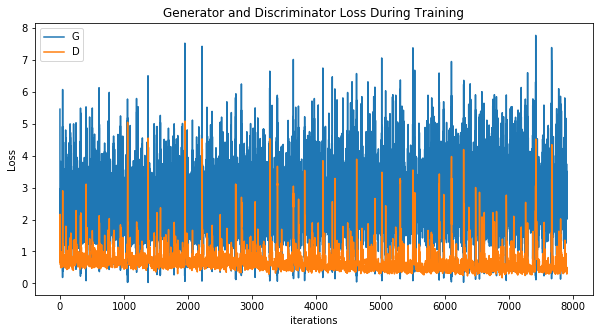

In [42]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
import imageio
images = []
for e in range(epochs):
    img_name = 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

*Real images vs. Fake images*

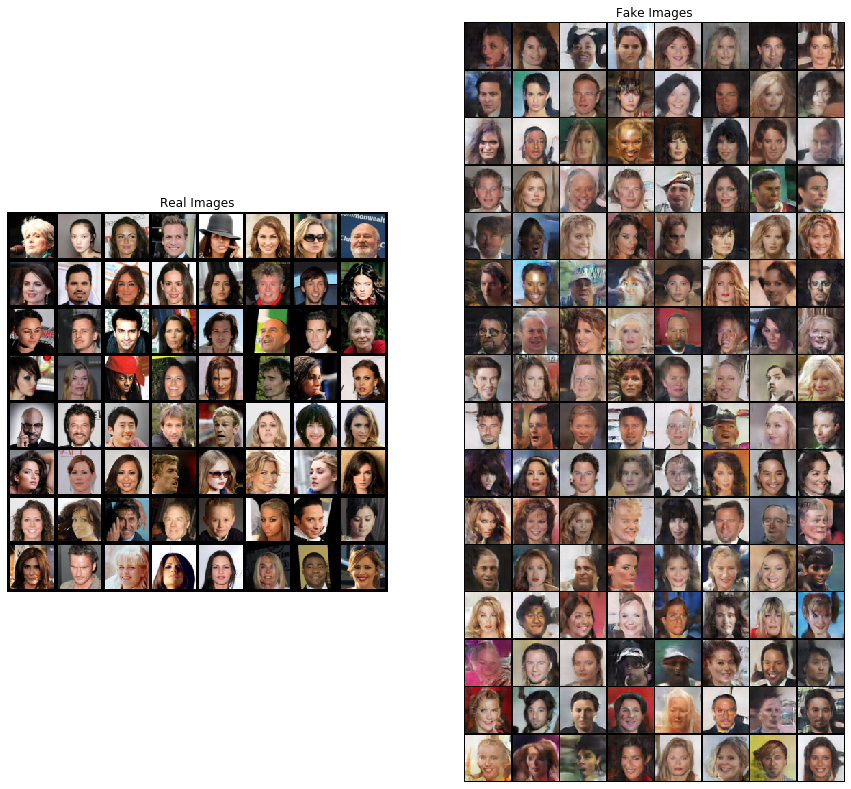

In [49]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")

plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


## MNIST

The next example was taken from [11] where the idea is to use GAN for make fake data from MNIST.

*packages*

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

*loading the data*

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms

# subprocess to use for data loading
workers = 0
# how many samples per batch to load
batch_size = 64
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="data", train=True, download=True, transform= transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=workers)

*Visualize the data*

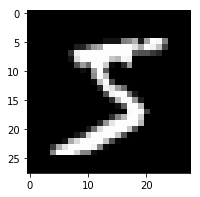

In [8]:
digit = iter(train_loader)
images, labels = digit.next()
images = images.numpy()
img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap="gray")

*Defining the model*

Our descriminator network is going to be a typical linear classifier, all hidden layers will have a Leaky ReLu activation function [10] applied to their outputs, according to [11] we should have the next schema for defining a model:
+ in the first layer, we need to flatten the image
+ define the structure of all hidden linear layers
+ add a dropout layer to avoid overfitting
+ once the hidden structure was done we must propose the fully-connected layer

__Discrimator__

In [26]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)
        
        return out

**Generator**

This is similar like the discrimator with a difference that it uses a tanh activation function to our output layer, where the idea is scales the output between -1 and 1. According to [11], the next is the structure for our generator model. 
+ It is a part to define all hidden linear layers
+ Once the hidden part was defined so the idea is to connect it with a fully-connected layer
+ add a dropout layer to avoid the overfitting
+ in the last layer the idea is applying a tanh function.

In [30]:
class Generator(nn.Module):
    
    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))
        return out 

**Model hyperparameters**

This a good part to experiment
1. Size of the input image to descriminator (28*28=784)
2. Size of descriminator output (real or fake)
3. Size of last hidden layer in the discriminator
4. Size of latent vector to give to the generator
5. Size of discriminator output (generated image)
6. Size of first hidden layer in the generator

In [31]:
# Dicrimnator hyperparams

# Size of input image to discrimator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discrimator output (generated image)
g_output_size = 784
# Size of first hidden layer in generator
g_hidden_size = 32

*Let's build the complete network*

In [32]:
# insstantiate discriminator and generator 
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

In [33]:
print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


**Defining losses**

+ *For the discriminator*, the total loss is the sum of the losses for real and fake 

$ \text{image}, \text{d_loss}= \text{d_real_loss} + \text{d_fake_loss} $

+ For this case we want the descriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that. 

+ The generator loss will look similar only with flipped labels. The generator's goal is to get D(fake_image)=1


In [34]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
    # smooth, real labels = 0.9
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


**Optimizers**

The idea is to update the generator and discriminator variables individually

In [38]:
import torch.optim as optim 

# Optimizers

lr = 0.002 

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

**Training**

These are the activities in both neural networks.

*Discriminator training*
1. Compute the discriminator loss on real, training images
2. Generate fake images
3. Compute the discriminator loss on fake, generated images.
4. Add up the real and fake losses
5. Perform backpropagation + an optimization step to update the descriminator's weights

*Generator training*
1. Generate fake images
2. Compute the discriminator loss on fake images, using *Flipped* labels
3. Perform backpropagation + an optimization step to update the discriminato's weights. 


In [42]:
from datetime import datetime
import pickle as pkl 


start=datetime.now()

# training hyperparameters
num_epochs = 100
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images tht are held
# constant throughout, and allow us to inspect the model's performance 
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = real_images * 2-1 # rescale input images from [0,1) to [-1, 1)
        
        # ---train the discriminator
        d_optimizer.zero_grad()
        # 1. train with real images
        # compute the discriminator losses on real images
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. train with fake images
        
        # generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up the loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # ---train the generator
        g_optimizer.zero_grad()
        
        # 1. train with fake images and flipped labels
        
        # generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # compute the discriminator losses on fake images
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        # print some loss stats
        if batch_i % print_every == 0:
            # printing the discriminator and generator losses
            print("Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(epoch+1, num_epochs, d_loss.item(),
                                                                                  g_loss.item()))
    # after each epoch the idea is to append the discriminator and generator lossses
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
    
# save the training generator samples
with open("train_samples.pkl", "wb") as f:
    pkl.dump(samples, f)
    
# print the time that the algorithm takes      

print (datetime.now()-start)

Epoch [    1/  100] | d_loss: 0.7146 | g_loss: 4.3246
Epoch [    1/  100] | d_loss: 1.2395 | g_loss: 1.1246
Epoch [    1/  100] | d_loss: 1.2407 | g_loss: 0.9284
Epoch [    2/  100] | d_loss: 1.1805 | g_loss: 0.9175
Epoch [    2/  100] | d_loss: 0.9218 | g_loss: 1.4583
Epoch [    2/  100] | d_loss: 1.0773 | g_loss: 1.9413
Epoch [    3/  100] | d_loss: 1.0598 | g_loss: 1.7568
Epoch [    3/  100] | d_loss: 1.0221 | g_loss: 1.4647
Epoch [    3/  100] | d_loss: 1.0479 | g_loss: 1.5988
Epoch [    4/  100] | d_loss: 1.1669 | g_loss: 2.0837
Epoch [    4/  100] | d_loss: 0.8550 | g_loss: 2.1305
Epoch [    4/  100] | d_loss: 1.2312 | g_loss: 1.0901
Epoch [    5/  100] | d_loss: 1.1259 | g_loss: 1.1048
Epoch [    5/  100] | d_loss: 0.9413 | g_loss: 1.2967
Epoch [    5/  100] | d_loss: 1.1337 | g_loss: 1.1700
Epoch [    6/  100] | d_loss: 1.1484 | g_loss: 1.2350
Epoch [    6/  100] | d_loss: 1.1403 | g_loss: 1.3754
Epoch [    6/  100] | d_loss: 1.0789 | g_loss: 1.5001
Epoch [    7/  100] | d_loss

*Let's plot the losses*

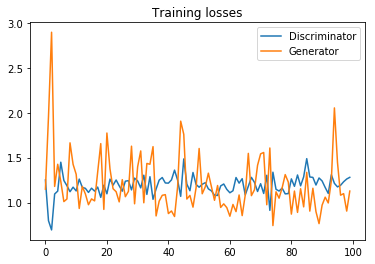

In [44]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator")
plt.plot(losses.T[1], label="Generator")
plt.title("Training losses")
plt.legend()

*Generator samples from training*

Let's see some samples from the generator.

In [45]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap="Greys_r")

In [46]:
# load samples from generator, taken while training
with open("train_samples.pkl", "rb") as f:
    samples = pkl.load(f)

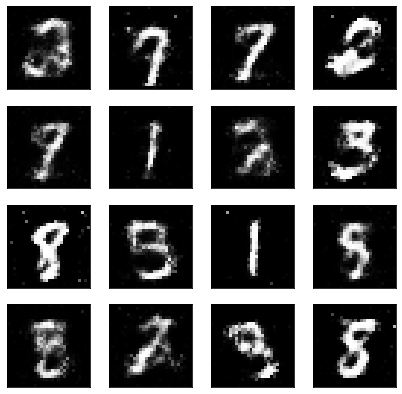

In [47]:
view_samples(-1, samples)

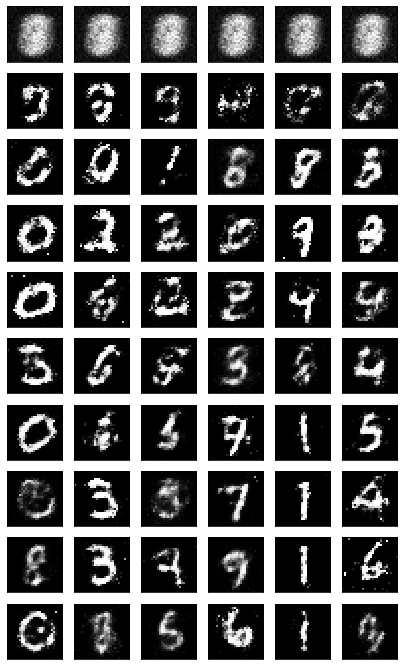

In [48]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

*Sampling from the generator*

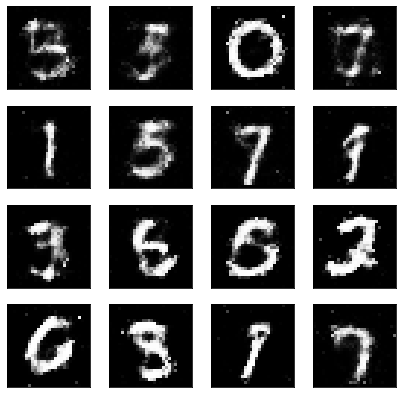

In [49]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

### Conditional GAN (cGAN)


This explanation was took from [7] which explains how using cGAN. It illustrates that cGAN is a type that involves the conditional generation of images by a generator model. Image generation can be conditional on a class label allowing the targeted generated of images of a given type. 

The idea behind cGAN is using the class label of the data in order to improve the GAN and targeted image generation. A GAN can be trained where both the generator and discriminator models are conditioned on the class label. 
```
Generative adversarial nets can be extended to a conditional model if both the generator and discriminator are conditioned on some extra information y. […] We can perform the conditioning by feeding y into the both the discriminator and generator as additional input layer.
```

*cGAN*

In this example we are going to explore how use cGAN in MNIST digits. 

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
# subprocess to use for data loading
workers = 0
# how many samples per batch to load
batch_size = 32
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="data", train=True, download=True, transform= transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=workers)

__Discrimator__

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

**Generator**



In [4]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
            
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [5]:
# Dicrimnator hyperparams

# Size of input image to discrimator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
# d_output_size = 1
# Size of last hidden layer in the discriminator
# d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discrimator output (generated image)
# g_output_size = 784
# Size of first hidden layer in generator
# g_hidden_size = 32

In [6]:
# instantiate discriminator and generator 
D = Discriminator()
G = Generator()

In [7]:
print(D)
print(G)

Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)
Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(

In [9]:
import torch.optim as optim 

z_size = 100

# Optimizers

lr = 0.002 

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr=1e-4)
g_optimizer = optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [11]:
torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, z_size))).float().size()

torch.Size([32, 100])

In [10]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    # 1. train with real images
    # compute the discriminator losses on real images
    # smooth the real labels
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss =  criterion(validity, Variable(torch.ones(batch_size)))
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [11]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    
    # train with real images
    real_validity =  discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)))
    
    # train with fake images
#     z = np.random.uniform(-1, 1, size=(batch_size, z_size))
#     z = torch.from_numpy(z).float()
    z = Variable(torch.randn(batch_size, 100))
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))
    fake_images = generator(z, fake_labels)    
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss

In [12]:
from datetime import datetime
import pickle as pkl 
from torch.autograd import Variable


start=datetime.now()

# training hyperparameters
num_epochs = 50
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images tht are held
# constant throughout, and allow us to inspect the model's performance 
# sample_size = 16
# fixed_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
# fixed_z = torch.from_numpy(fixed_z).float()
# fixed_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size)))

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (images, labels) in enumerate(train_loader):
#         batch_size = images.size(0)
        
        # important rescaling step
        real_images = images * 2-1 # rescale input images from [0,1) to [-1, 1)
        
        # -------train the discriminator
        real_images = Variable(images)
        labels = Variable(labels)
        
        d_loss = discriminator_train_step(len(real_images), D, G, d_optimizer, criterion,
                                          real_images, labels)
    
        # -------train the generator
        g_loss = generator_train_step(batch_size, D, G, g_optimizer, criterion)
       
        # print some loss stats
        if batch_i % print_every == 0:
            # printing the discriminator and generator losses
            print("Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(epoch+1, num_epochs, d_loss.item(),
                                                                                  g_loss.item()))
    # after each epoch the idea is to append the discriminator and generator lossses
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples

    z = Variable(torch.randn(9, 100))
    labels = Variable(torch.LongTensor(np.arange(9)))
    sample_images = G(z, labels).unsqueeze(1)
    samples.append(sample_images)
    G.train() # back to train mode
    
# save the training generator samples
with open("train_samples_cGAN.pkl", "wb") as f:
    pkl.dump(sample_images, f)
    
# print the time that the algorithm takes      

print (datetime.now()-start)

Epoch [    1/   50] | d_loss: 1.3830 | g_loss: 0.6897
Epoch [    1/   50] | d_loss: 1.4541 | g_loss: 0.4794
Epoch [    1/   50] | d_loss: 1.8688 | g_loss: 0.9452
Epoch [    1/   50] | d_loss: 0.8243 | g_loss: 2.7086
Epoch [    1/   50] | d_loss: 0.8850 | g_loss: 2.1650
Epoch [    2/   50] | d_loss: 0.3270 | g_loss: 2.6449
Epoch [    2/   50] | d_loss: 0.9739 | g_loss: 2.2401
Epoch [    2/   50] | d_loss: 0.3277 | g_loss: 2.5862
Epoch [    2/   50] | d_loss: 0.3765 | g_loss: 2.2043
Epoch [    2/   50] | d_loss: 1.1627 | g_loss: 2.5748
Epoch [    3/   50] | d_loss: 1.7336 | g_loss: 1.9366
Epoch [    3/   50] | d_loss: 0.4397 | g_loss: 3.1489
Epoch [    3/   50] | d_loss: 0.4697 | g_loss: 2.4976
Epoch [    3/   50] | d_loss: 0.7382 | g_loss: 2.1551
Epoch [    3/   50] | d_loss: 1.2186 | g_loss: 2.2982
Epoch [    4/   50] | d_loss: 0.7485 | g_loss: 2.7892
Epoch [    4/   50] | d_loss: 0.6045 | g_loss: 3.3464
Epoch [    4/   50] | d_loss: 0.5792 | g_loss: 2.0922
Epoch [    4/   50] | d_loss

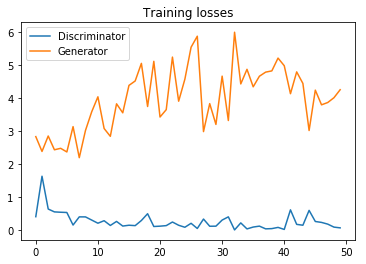

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator")
plt.plot(losses.T[1], label="Generator")
plt.title("Training losses")
plt.legend()

(-0.5, 301.5, 301.5, -0.5)

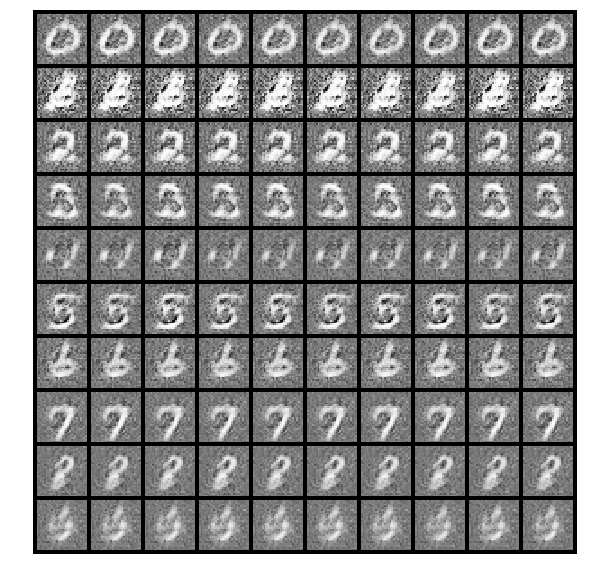

In [23]:
from torchvision.utils import make_grid

z = Variable(torch.randn(100, 100))
labels = torch.LongTensor([i for i in range(10) for _ in range(10)])

images = G(z, labels).unsqueeze(1)
grid = make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).data, cmap='binary')
ax.axis('off')

In [21]:
def generate_digit(generator, digit):
    z = Variable(torch.randn(1, 100))
    label = torch.LongTensor([digit])
    img = generator(z, label).data.cpu()
    img = 0.5 * img + 0.5
    return transforms.ToPILImage()(img)

In [22]:
generate_digit(G, 8)

In [26]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap="Greys_r")

In [24]:
# load samples from generator, taken while training
with open("train_samples_cGAN.pkl", "rb") as f:
    samples = pkl.load(f)

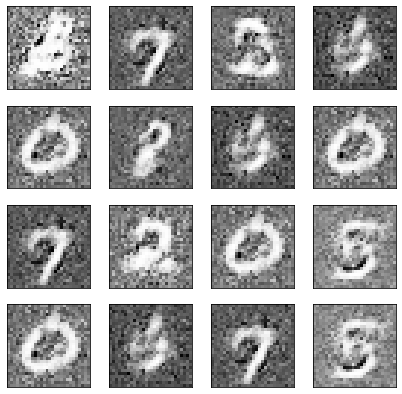

In [28]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
labels = Variable(torch.LongTensor(np.random.randint(0, 10, sample_size)))

G.eval() # eval mode
# generated samples
rand_images = G(rand_z, labels)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

https://github.com/arturml/mnist-cgan/blob/master/mnist-cgan.ipynb

https://www.kaggle.com/arturlacerda/pytorch-conditional-gan

### cDCGAN

The conditional training of the DCGAN-based models may be referred to as CDCGAN or cDCGAN.

According to [7], the are many ways to incorporate the class labels into the discriminator and generator models. *A best practice involves using a embedding layer followed by a fully connected layer with a linear activation that scales the embedding to the size of the image before concatenating it in the model as an additional channel or feature map*, a recommendation mentioned in [13] 
```
… we also explore a class conditional version of the model, where a vector c encodes the label. This is integrated into Gk & Dk by passing it through a linear layer whose output is reshaped into a single plane feature map which is then concatenated with the 1st layer maps.
```

In this example [14] is going to be explored how using cDCGAN model architecture in the fashion-MNIST clothing dataset and MNIST digits, with the next architectures 

<img src="https://github.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN/raw/master/pytorch_cDCGAN.png" >

### *cDCGAN MNIST Digits*

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

*Loading the data*

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# subprocess to use for data loading
workers = 0
# how many samples per batch to load
batch_size = 138
img_size = 32
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])
train_data = datasets.MNIST(root="data", train=True, download=True, transform= transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=workers, shuffle=True)

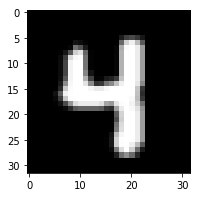

In [3]:
digit = iter(train_loader)
images, labels = digit.next()
images = images.numpy()
img = np.squeeze(images[0])

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap="gray")

In [4]:
print("the number of images(batch) is %s and they are %s x %s" %(str(images.shape[0]),str(images.shape[2]),str(images.shape[3])))

the number of images(batch) is 138 and they are 32 x 32


In [5]:
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
```

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Discriminator(nn.Module):
    
    def __init__(self, d, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1_1 = nn.Conv2d(1, 64, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)
        
    def forward(self, x, labels):      
        x = F.leaky_relu(self.conv1_1(x), 0.2)
        y = F.leaky_relu(self.conv1_2(labels), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))

        return x

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Generator(nn.Module):
    
    def __init__(self, d, ngpu):
        super(Generator, self).__init__()
        
#         self.label_emb = nn.Embedding(10, 10)
        
        # gpus
        self.ngpu = ngpu
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)
    
    def forward(self, z, label):       
        
        z = F.relu(self.deconv1_1_bn(self.deconv1_1(z)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        z = torch.cat([z, y], 1)
        z = F.relu(self.deconv2_bn(self.deconv2(z)))
        z = F.relu(self.deconv3_bn(self.deconv3(z)))
        z = torch.tanh(self.deconv4(z))

        return z

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
# Create the Generator 
G = Generator(d=128, ngpu=ngpu)

# # handle multi-gpu if desired 
if (device.type == "cuda") and (ngpu > 1):
    G = nn.DataParallel(netG, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
G.apply(weights_init)
G.cuda()
print(G)

Generator(
  (deconv1_1): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_1_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1_2): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [10]:
# Create the Discriminator 
D = Discriminator(d=128, ngpu=ngpu)
# handle multi-gpu if desired 
if (device.type == "cuda") and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev = 0.2
D.apply(weights_init)
D.cuda()

print(D)

Discriminator(
  (conv1_1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_2): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
)


*Optimizers*

In [11]:
import torch.optim as optim 

# Optimizers

lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)
criterion = nn.BCELoss()

*Training*

In [12]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    # 1. train with real images
    # compute the discriminator losses on real images
    # smooth the real labels
    g_optimizer.zero_grad()
    z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1)
    y = (torch.rand(batch_size, 1) * 10).type(torch.LongTensor).squeeze()
    y_label_ = onehot[y_]
    y_fill_ = fill[y_]
    z_, y_label_, y_fill_ = Variable(z.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())
    
    G_result = generator(z_, y_label_)
    D_result = discriminator(G_result, y_fill_).squeeze()
    
    g_loss =  criterion(D_result, Variable(torch.ones(batch_size).cuda()))
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [13]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    # train with real images
    real_validity =  discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size).cuda()))
    
    # train with fake images
    z = Variable(torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda())
    y_ = (torch.rand(batch_size, 1) * 10).type(torch.LongTensor).squeeze()
    y_label_ = onehot[y_]
    y_fill_ = fill[y_]    
    fake_images = generator(z, Variable(y_label_.cuda()))  
    fake_validity = discriminator(fake_images, Variable(y_fill_.cuda()))
    
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size).cuda()))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss

In [14]:
onehot = torch.zeros(10, 10)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10, 1), 1).view(10, 10, 1, 1)
fill = torch.zeros([10, 10, 32, 32])

for i in range(10):
    fill[i, i, :, :] = 1
    
fill.size()

torch.Size([10, 10, 32, 32])

In [15]:
from torch.autograd import Variable
# fixed noise & label
temp_z_ = torch.randn(10, 100)
fixed_z_ = temp_z_
fixed_y_ = torch.zeros(10, 1)
for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], 0)
    temp = torch.ones(10, 1) + i
    fixed_y_ = torch.cat([fixed_y_, temp], 0)

fixed_z_ = fixed_z_.view(-1, 100, 1, 1)
fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
fixed_y_label_ = fixed_y_label_.view(-1, 10, 1, 1)
fixed_z_, fixed_y_label_ = Variable(fixed_z_.cuda(), volatile=True), Variable(fixed_y_label_.cuda(), volatile=True)

D:\Usuarios\rhaps\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


In [16]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [17]:
import os
import matplotlib.pyplot as plt
import itertools

root = 'MNIST_cDCGAN_results/'
model = 'MNIST_cDCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

In [18]:
from datetime import datetime
import pickle as pkl 
from torch.autograd import Variable

start=datetime.now()

# training hyperparameters
num_epochs = 20
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images tht are held
# constant throughout, and allow us to inspect the model's performance 
sample_size = 16

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (images, y_) in enumerate(train_loader):
#         batch_size = images.size(0)
        
        # important rescaling step
        real_images = images * 2-1 # rescale input images from [0,1) to [-1, 1)
        
        real_images = Variable(real_images.cuda())
#         labels = Variable(labels)
        # -------train the discriminator
        labels = Variable(fill[y_].cuda())
        
        d_loss = discriminator_train_step(len(real_images), D, G, d_optimizer, criterion,
                                          real_images, labels)
        
         # -------train the generator
        
        g_loss = generator_train_step(len(real_images), D, G, g_optimizer, criterion)
       
        
        # print some loss stats
        if batch_i % print_every == 0:
            # printing the discriminator and generator losses
            print("Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(epoch+1, num_epochs, d_loss.item(),
                                                                                  g_loss.item()))
    # after each epoch the idea is to append the discriminator and generator lossses
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
#     G.eval() # eval mode for generating samples
#     samples_z = G(fixed_z_, fixed_y_label_)
#     samples.append(samples_z)
#     G.train() # back to train mode
    
    fixed_p = 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=fixed_p)
    
# save the training generator samples
with open("train_samples_dcgan.pkl", "wb") as f:
    pkl.dump(samples, f)
    
# print the time that the algorithm takes      

print (datetime.now()-start)

D:\Usuarios\rhaps\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([138])) that is different to the input size (torch.Size([138, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [    1/   20] | d_loss: 2.0561 | g_loss: 6.3234
Epoch [    1/   20] | d_loss: 0.0919 | g_loss: 5.4174


D:\Usuarios\rhaps\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([108])) that is different to the input size (torch.Size([108, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [    2/   20] | d_loss: 0.0733 | g_loss: 4.8043
Epoch [    2/   20] | d_loss: 0.0740 | g_loss: 6.4189
Epoch [    3/   20] | d_loss: 0.0535 | g_loss: 4.3910
Epoch [    3/   20] | d_loss: 0.0528 | g_loss: 4.7421
Epoch [    4/   20] | d_loss: 0.0726 | g_loss: 5.2361
Epoch [    4/   20] | d_loss: 0.0555 | g_loss: 6.0891
Epoch [    5/   20] | d_loss: 0.0459 | g_loss: 6.0589
Epoch [    5/   20] | d_loss: 0.0541 | g_loss: 6.1603
Epoch [    6/   20] | d_loss: 0.0098 | g_loss: 4.1088
Epoch [    6/   20] | d_loss: 0.1152 | g_loss: 7.5290
Epoch [    7/   20] | d_loss: 0.0370 | g_loss: 6.7881
Epoch [    7/   20] | d_loss: 0.0248 | g_loss: 6.4693
Epoch [    8/   20] | d_loss: 0.0568 | g_loss: 5.7434
Epoch [    8/   20] | d_loss: 0.0595 | g_loss: 4.8781
Epoch [    9/   20] | d_loss: 0.0691 | g_loss: 6.5044
Epoch [    9/   20] | d_loss: 0.0207 | g_loss: 5.9224
Epoch [   10/   20] | d_loss: 0.3588 | g_loss: 7.9169
Epoch [   10/   20] | d_loss: 0.0252 | g_loss: 8.1977
Epoch [   11/   20] | d_loss

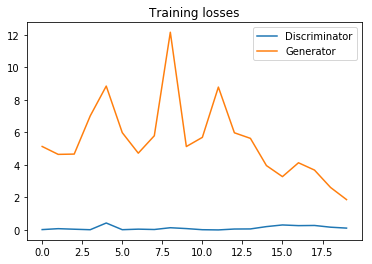

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label="Discriminator")
plt.plot(losses.T[1], label="Generator")
plt.title("Training losses")
plt.legend()

In [24]:
# save the training generator samples
with open("cdcgan_generator.pkl", "wb") as f:
    pkl.dump(G, f)

In [5]:
import pickle as pkl 
# load samples from generator, taken while training
with open("cdcgan_generator.pkl", "rb") as f:
    G = pkl.load(f)

with open("train_samples_cGAN.pkl", "rb") as f:
    samples = pkl.load(f)

In [23]:
import imageio
images = []
for e in range(num_epochs):
    img_name = 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

<img src="MNIST_cDCGAN_results/MNIST_cDCGAN_generation_animation.gif" >

### *Celeb cDCGAN*

For this example we are going to use the gender as condition

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
dataroot = "../../../Datasets/celeba"
batch_size = 128
image_size = 64
workers = 0    
ngpu = 1

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([                               
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# dataloader 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

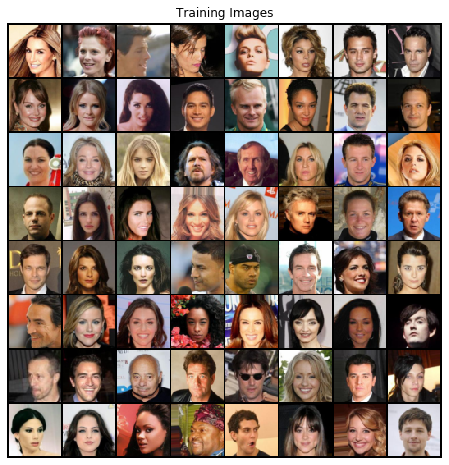

In [4]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
real_batch = next(iter(dataloader))
print("the number of images(batch) is %s and they are %s x %s with a depth of %s" %(str(real_batch[0].size()[0]),str(real_batch[0].size()[2]),str(real_batch[0].size()[3]), str(real_batch[0].size()[1])))

the number of images(batch) is 128 and they are 64 x 64 with a depth of 3


In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Discriminator(nn.Module):
    
    def __init__(self, d, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv1_1 = nn.Conv2d(3, 64, 4, 2, 1) #3 channels
        self.conv1_2 = nn.Conv2d(2, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 0)
        
    def forward(self, x, labels):      
        x = F.leaky_relu(self.conv1_1(x), 0.2)
        y = F.leaky_relu(self.conv1_2(labels), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Generator(nn.Module):
    
    def __init__(self, d, ngpu):
        super(Generator, self).__init__()
        
#         self.label_emb = nn.Embedding(10, 10)
        
        # gpus
        self.ngpu = ngpu
        self.deconv1_1 = nn.ConvTranspose2d(100, d*4, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*4)
        self.deconv1_2 = nn.ConvTranspose2d(2, d*4, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)
    
    def forward(self, z, label):       
        
        z = F.leaky_relu(self.deconv1_1_bn(self.deconv1_1(z)),     0.2)
        y = F.leaky_relu(self.deconv1_2_bn(self.deconv1_2(label)), 0.2)
        z = torch.cat([z, y], 1)
        z = F.leaky_relu(self.deconv2_bn(self.deconv2(z)), 0.2)
        z = F.leaky_relu(self.deconv3_bn(self.deconv3(z)), 0.2)
        z = F.leaky_relu(self.deconv4_bn(self.deconv4(z)), 0.2)
        z = torch.tanh(self.deconv5(z))

        return z

In [9]:
# Create the Generator 
G = Generator(d=128, ngpu=ngpu)

# # handle multi-gpu if desired 
if (device.type == "cuda") and (ngpu > 1):
    G = nn.DataParallel(netG, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
G.apply(weights_init)
G.cuda()
print(G)

Generator(
  (deconv1_1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1_2): ConvTranspose2d(2, 512, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding

In [10]:
# Create the Discriminator 
D = Discriminator(d=128, ngpu=ngpu)
# handle multi-gpu if desired 
if (device.type == "cuda") and (ngpu > 1):
    D = nn.DataParallel(D, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev = 0.2
D.apply(weights_init)
D.cuda()

print(D)

Discriminator(
  (conv1_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_2): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)


In [11]:
import torch.optim as optim 

# Optimizers

lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)
criterion = nn.BCELoss()

In [12]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    # 1. train with real images
    # compute the discriminator losses on real images
    # smooth the real labels
    g_optimizer.zero_grad()
    z = torch.randn((batch_size, 100)).view(-1, 100, 1, 1)
    y_ = (torch.rand(batch_size, 1) * 2).type(torch.LongTensor).squeeze()
    y_label_ = onehot[y_]
    y_fill_ = fill[y_]
    z_, y_label_, y_fill_ = Variable(z.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())
    
    G_result = generator(z_, y_label_)
    D_result = discriminator(G_result, y_fill_).squeeze()
    
    g_loss =  criterion(D_result, Variable(torch.ones(batch_size).cuda()))
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [13]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    # train with real images
    real_validity =  discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size).cuda()))
    
    # train with fake images
    z = Variable(torch.randn((batch_size, 100)).view(-1, 100, 1, 1).cuda())
    y_ = (torch.rand(batch_size, 1) * 2).type(torch.LongTensor).squeeze()
    y_label_ = onehot[y_]
    y_fill_ = fill[y_]    
    fake_images = generator(z, Variable(y_label_.cuda()))  
    fake_validity = discriminator(fake_images, Variable(y_fill_.cuda()))
    
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size).cuda()))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss

In [14]:
# a binary tensor which is going to indentify gender 
onehot = torch.zeros(2, 2)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1]).view(2, 1), 1).view(2, 2, 1, 1)
fill = torch.zeros([2, 2, 64, 64])

for i in range(2):
    fill[i, i, :, :] = 1
    
fill.size()

torch.Size([2, 2, 64, 64])

In [15]:
import pickle as pkl 
import numpy as np
import torch
# import cv2
with open('gender_label.pkl', 'rb') as fp:
    y_gender_ = pkl.load(fp)
    
y_gender_ = torch.LongTensor(y_gender_).squeeze()

y_gender_

tensor([0, 0, 1,  ..., 1, 0, 0])

In [16]:
from torch.autograd import Variable
temp_z0_ = torch.randn(4, 100)
temp_z0_ = torch.cat([temp_z0_, temp_z0_], 0)
temp_z1_ = torch.randn(4, 100)
temp_z1_ = torch.cat([temp_z1_, temp_z1_], 0)

fixed_z_ = torch.cat([temp_z0_, temp_z1_], 0)
fixed_y_ = torch.cat([torch.zeros(4), torch.ones(4), torch.zeros(4), torch.ones(4)], 0).type(torch.LongTensor).squeeze()

fixed_z_ = fixed_z_.view(-1, 100, 1, 1)
fixed_y_label_ = onehot[fixed_y_]
fixed_z_, fixed_y_label_ = Variable(fixed_z_.cuda(), volatile=True), Variable(fixed_y_label_.cuda(), volatile=True)

C:\Users\Usuario\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


In [17]:
fixed_z_.size()

torch.Size([16, 100, 1, 1])

In [18]:
fixed_y_label_.size()

torch.Size([16, 2, 1, 1])

In [19]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 16
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(4*4):
        i = k // 4
        j = k % 4
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [20]:
import os
import matplotlib.pyplot as plt
import itertools

root = 'FASHION_cDCGAN_results/'
model = 'FASHION_cDCGAN_'
if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

In [ ]:
from datetime import datetime
import pickle as pkl 
from torch.autograd import Variable

start=datetime.now()

# training hyperparameters
num_epochs = 20
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images tht are held
# constant throughout, and allow us to inspect the model's performance 
sample_size = 16

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    for batch_i, (real_images, l) in enumerate(dataloader):
#         batch_size = images.size(0)
        
        # important rescaling step
#         real_images = real_images * 2-1 # rescale input images from [0,1) to [-1, 1)
        
        real_images = Variable(real_images.cuda())
#         labels = Variable(labels)
        # -------train the discriminator
        
        y_ = y_gender_[batch_size * batch_i: batch_size * (batch_i + 1)]
        
        y_fill_ = fill[y_]
        
        labels = Variable(fill[y_].cuda())
        
        d_loss = discriminator_train_step(len(real_images), D, G, d_optimizer, criterion,
                                          real_images, labels)
        
         # -------train the generator
        
        g_loss = generator_train_step(len(real_images), D, G, g_optimizer, criterion)
       
        
        # print some loss stats
        if batch_i % print_every == 0:
            # printing the discriminator and generator losses
            print("Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}".format(epoch+1, num_epochs, d_loss.item(),
                                                                                  g_loss.item()))
    # after each epoch the idea is to append the discriminator and generator lossses
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
#     G.eval() # eval mode for generating samples
#     samples_z = G(fixed_z_, fixed_y_label_)
#     samples.append(samples_z)
#     G.train() # back to train mode
    
    fixed_p = 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=fixed_p)
    
# save the training generator samples
with open("train_fashion_dcgan.pkl", "wb") as f:
    pkl.dump(samples, f)
    
# print the time that the algorithm takes      

print (datetime.now()-start)

C:\Users\Usuario\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [    1/   20] | d_loss: 2.6385 | g_loss: 15.9895
Epoch [    1/   20] | d_loss: 0.0130 | g_loss: 6.6339
Epoch [    1/   20] | d_loss: 0.0926 | g_loss: 5.4049
Epoch [    1/   20] | d_loss: 0.0062 | g_loss: 8.6854


C:\Users\Usuario\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([103])) that is different to the input size (torch.Size([103, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [    2/   20] | d_loss: 2.2284 | g_loss: 6.3833
Epoch [    2/   20] | d_loss: 0.1049 | g_loss: 6.5527
Epoch [    2/   20] | d_loss: 0.0418 | g_loss: 6.5515
Epoch [    2/   20] | d_loss: 0.0584 | g_loss: 8.9815
Epoch [    3/   20] | d_loss: 0.1128 | g_loss: 6.5503
Epoch [    3/   20] | d_loss: 0.0277 | g_loss: 5.3506
Epoch [    3/   20] | d_loss: 0.1322 | g_loss: 5.3767
Epoch [    3/   20] | d_loss: 0.0833 | g_loss: 9.4141
Epoch [    4/   20] | d_loss: 0.0698 | g_loss: 9.3148
Epoch [    4/   20] | d_loss: 0.0445 | g_loss: 6.8416
Epoch [    4/   20] | d_loss: 0.1469 | g_loss: 8.7110
Epoch [    4/   20] | d_loss: 0.3703 | g_loss: 9.5032
Epoch [    5/   20] | d_loss: 0.2251 | g_loss: 8.3453
Epoch [    5/   20] | d_loss: 0.0545 | g_loss: 15.0025
Epoch [    5/   20] | d_loss: 0.1071 | g_loss: 7.5831
Epoch [    5/   20] | d_loss: 0.2852 | g_loss: 8.8591
Epoch [    6/   20] | d_loss: 0.1802 | g_loss: 4.9361
Epoch [    6/   20] | d_loss: 0.0048 | g_loss: 5.8627
Epoch [    6/   20] | d_los

another

https://www.kaggle.com/arturlacerda/pytorch-conditional-gan

https://github.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN

https://github.com/togheppi/cDCGAN

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

## References

+ [1] https://skymind.ai/wiki/generative-adversarial-network-gan
+ [2] https://forum.faceswap.dev/viewtopic.php?t=146
+ [3] https://developers.google.com/machine-learning/gan
+ [4] Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). Improved techniques for training gans. In Advances in neural information processing systems (pp. 2234-2242).
+ [5] Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). Gans trained by a two time-scale update rule converge to a local nash equilibrium. In Advances in neural information processing systems (pp. 6626-6637).
+ [6] Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.
+ [7] https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
+ [8] Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.
+ [9] https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
+ [10] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Leaky_ReLUs
+ [11] https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60
+ [12] Mirza, M., & Osindero, S. (2014). Conditional generative adversarial nets. arXiv preprint arXiv:1411.1784.
+ [13] Denton, E. L., Chintala, S., & Fergus, R. (2015). Deep generative image models using a￼ laplacian pyramid of adversarial networks. In Advances in neural information processing systems (pp. 1486-1494).